# This notebook walks through the basics of using TASM
It covers
- Loading metadata
- Loading videos and storing them with and without tiles
- Retrieving objects
- Retrieving full frames and tiles
- Automatically tiling videos as queries execute

# Setup: loading a video and detections.

If `configure_environment` is not called, TASM will create/add to a database at `./labels.db` and store videos in `./resources/`.

In [1]:
# Remove previously-stored videos, data.
import os
import shutil
import tasm

NOTEBOOK_RESOURCES_PATH = 'basics_resources'
if os.path.exists(NOTEBOOK_RESOURCES_PATH):
    shutil.rmtree(NOTEBOOK_RESOURCES_PATH)
os.mkdir(NOTEBOOK_RESOURCES_PATH)

tasm.configure_environment({
    'default_db_path': os.path.join(NOTEBOOK_RESOURCES_PATH, 'labels.db'),
    'catalog_path': os.path.join(NOTEBOOK_RESOURCES_PATH, 'resources') 
})

In [2]:
VIDEO_PATH = 'data/birds.mp4'
DETECTIONS_PATH = 'data/birds.pkl'

### Load detections.

In [3]:
import pandas as pd

detections = pd.read_pickle(DETECTIONS_PATH)
detections = detections.astype({'x1': int, 'y1': int, 'x2': int, 'y2': int})
detections.head()

,frame,label,x1,y1,x2,y2
0,0,bird,353,636,440,747
1,1,bird,353,636,442,747
2,2,bird,353,632,445,743
3,3,bird,353,636,443,743
4,4,bird,355,636,440,744


### View detections on a few frames.
Is it the most exciting video? No. But at one point I thought it was exciting enough to capture, so here we are.

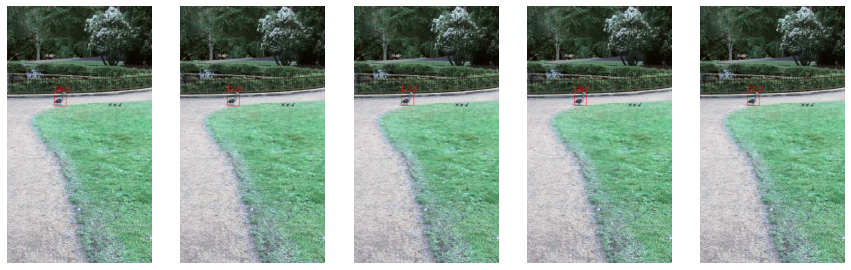

In [8]:
import cv2
import matplotlib.pyplot as plt

def draw_box(img, label, x1, y1, x2, y2):
    pt1 = (x1, y1)
    pt2 = (x2, y2)
    cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
    cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 2, [255, 0, 0], 2)
    return img

num_frames = 5
vc = cv2.VideoCapture(VIDEO_PATH)

f, axs = plt.subplots(1, num_frames, figsize=(15, 15))
[ax.axis('off') for ax in axs.ravel()]
for f in range(num_frames):
    ret, frame = vc.read()
    if not ret:
        break
        
    objects = detections[detections.frame == f]
    for i, row in objects.iterrows():
        frame = draw_box(frame, row.label, row.x1, row.y1, row.x2, row.y2)

    axs[f].imshow(frame)

# Loading the video and detections into TASM.

In [4]:
import os
import tasm

t = tasm.TASM()

# First, load the video without tiling into TASM.
untiled_video_name = 'birds-untiled'
t.store(VIDEO_PATH, untiled_video_name)

# We can also store it with a uniform layout, e.g. 2x2.
rows = 2
cols = 2
t.store_with_uniform_layout(VIDEO_PATH, 'birds-2x2', rows, cols)

In [5]:
# Add metadata about the video. 
# We could use t.add_metadata(video, label, frame, x1, y1, x2, y2).
# However, since we have all of the metadata available, we can use t.add_bulk_metadata to add all of it at once.
metadata_id = 'birds'
label = 'bird'
metadata_info = [
    tasm.MetadataInfo(metadata_id, r.label, r.frame, r.x1, r.y1, r.x2, r.y2) 
    for _, r in detections.iterrows()
]
t.add_bulk_metadata(metadata_info)

In [6]:
# Now, we can use the metadata to tile around birds.
tiled_video_name = 'birds-birds'
t.store_with_nonuniform_layout(VIDEO_PATH, tiled_video_name, metadata_id, label)

# Retrieving objects of interest using TASM.
Note that the objects may returned in any order (not necessarily in frame-ascending order).
Adding an option to return objects in frame-ascending order is tracked by https://github.com/maureendaum/TASM/issues/6.

Sometimes things go wrong when converting from the decoded frame to RGB. If you come across a case where any of the `select` functions returns corrupted-looking images, please create an issue at https://github.com/maureendaum/TASM/issues!

Detected 5 birds.


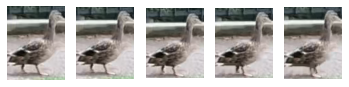

In [9]:
# First, let's retrieve a few birds from the un-tiled video.
first_frame_inclusive = 0
last_frame_exclusive = 5
tiled_selection = t.select(tiled_video_name, metadata_id, label, first_frame_inclusive, last_frame_exclusive)

# Inspect the returned instances.
num_birds = 0
num_cols = 5
f, axs = plt.subplots(1, num_cols)
[ax.axis('off') for ax in axs.ravel()]
while True:
    bird = tiled_selection.next()
    if bird.is_empty():
        break
    w = bird.width()
    h = bird.height()
    axs[num_birds].imshow(bird.numpy_array())
    num_birds += 1
print(f'Detected {num_birds} birds.')

In [10]:
import time

def time_selection(video_name, metadata_id, label, first_frame=None, last_frame=None):
    start = time.perf_counter()
    selection = t.select(video_name, metadata_id, label, first_frame, last_frame) \
                        if first_frame is not None and last_frame is not None \
                        else t.select(video_name, metadata_id, label)
    num_objs = 0
    while True:
        obj = selection.next()
        if obj.is_empty():
            break
        num_objs += 1
    end = time.perf_counter()
    return end - start, num_objs

In [11]:
# Compare the time to retrieve all of the birds from the untiled video from the tiled video.
# By not specifying first frame and last frame, TASM selects all instances of the object from the video.
dur, num_birds = time_selection(untiled_video_name, metadata_id, label)
print(f'Untiled video: Retrieved {num_birds} birds in {dur}')

dur, num_birds = time_selection(tiled_video_name, metadata_id, label)
print(f'Tiled video: Retrieved {num_birds} birds in {dur}')

Retrieved 1209 birds in 1.445235550403595
Retrieved 1209 birds in 0.2693198546767235


# Retrieving full frames and full tiles from videos

## Retrieve entire tiles containing objects of interest.
Use the `select_tiles` function.

Decoded 5 tiles


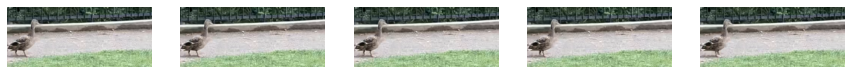

In [12]:
tiled_selection = t.select_tiles(tiled_video_name, metadata_id, label, first_frame_inclusive, last_frame_exclusive)
num_tiles = 0
num_cols = 5
f, axs = plt.subplots(1, num_cols, figsize=(15, 15))
[ax.axis('off') for ax in axs.ravel()]
while True:
    tile = tiled_selection.next()
    if tile.is_empty():
        break
    axs[num_tiles].imshow(tile.numpy_array())
    num_tiles += 1
print(f'Decoded {num_tiles} tiles')

## Retrieve entire frames containing objects of interest.
Use the `select_frames` function with any tiled or untiled video.

Decoded 5 frames


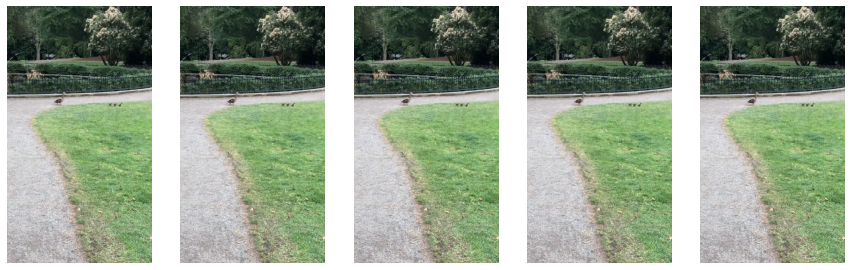

In [13]:
frame_selection = t.select_frames(tiled_video_name, metadata_id, label, first_frame_inclusive, last_frame_exclusive)
num_frames = 0
num_cols = 5
f, axs = plt.subplots(1, num_cols, figsize=(15, 15))
[ax.axis('off') for ax in axs.ravel()]
while True:
    frame = frame_selection.next()
    if frame.is_empty():
        break
    axs[num_frames].imshow(frame.numpy_array())
    num_frames += 1
print(f'Decoded {num_frames} frames')

Decoded 5 frames


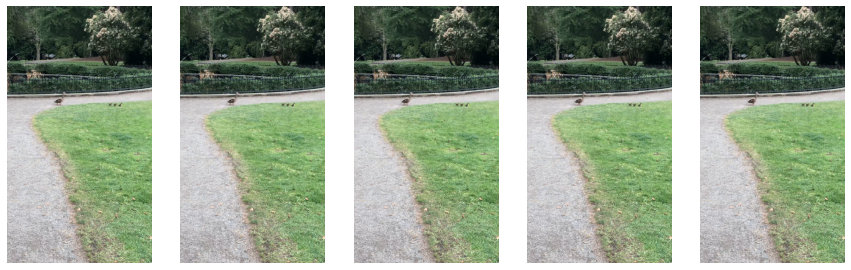

In [14]:
frame_selection = t.select_frames(untiled_video_name, metadata_id, label, first_frame_inclusive, last_frame_exclusive)
num_frames = 0
num_cols = 5
f, axs = plt.subplots(1, num_cols, figsize=(15, 15))
[ax.axis('off') for ax in axs.ravel()]
while True:
    frame = frame_selection.next()
    if frame.is_empty():
        break
    axs[num_frames].imshow(frame.numpy_array())
    num_frames += 1
print(f'Decoded {num_frames} frames')

Decoded 5 frames


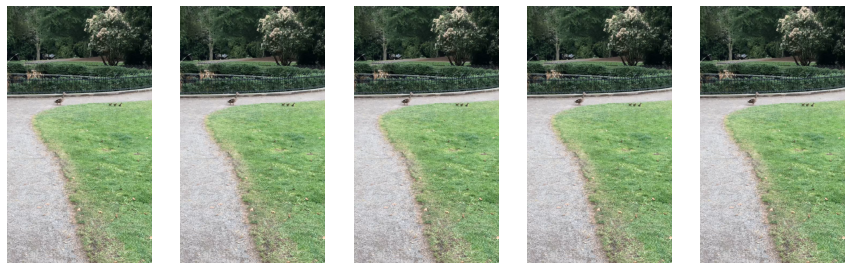

In [15]:
frame_selection = t.select_frames('birds-2x2', metadata_id, label, first_frame_inclusive, last_frame_exclusive)
num_frames = 0
num_cols = 5
f, axs = plt.subplots(1, num_cols, figsize=(15, 15))
[ax.axis('off') for ax in axs.ravel()]
while True:
    frame = frame_selection.next()
    if frame.is_empty():
        break
    axs[num_frames].imshow(frame.numpy_array())
    num_frames += 1
print(f'Decoded {num_frames} frames')

# Automatically tiling a video.

In [16]:
# Start with an untiled video.
t = tasm.TASM()
incrementally_tiled_name = 'birds-incremental'
t.store(VIDEO_PATH, incrementally_tiled_name)

In [17]:
# Perform 10 selections on the un-tiled video over the first 5 seconds.
first_frame_inclusive = 0
last_frame_exclusive = 150
num_selections = 10
start = time.perf_counter()
for i in range(num_selections):
    time_selection(incrementally_tiled_name, metadata_id, label, first_frame_inclusive, last_frame_exclusive)
print(f'{num_selections} selections over the untiled video took {time.perf_counter() - start}')

10 selections over the untiled video took 7.142789863049984


In [18]:
# To automatically tile a video, we must first activate it so TASM will start tracking regret.
# Activate regret-based re-tiling.
t.activate_regret_based_tiling(incrementally_tiled_name, metadata_id)

# Perform 0 selections with incremental tiling over the first 5 seconds.
# Currently, the call to re-tile must be manually specified.
# Moving this into the selection calls is tracked at https://github.com/maureendaum/TASM/issues/5.
start = time.perf_counter()
for i in range(num_selections):
    time_selection(incrementally_tiled_name, metadata_id, label, first_frame_inclusive, last_frame_exclusive)
    t.retile_based_on_regret(incrementally_tiled_name)
print(f'{num_selections} selections with incremental tiling took {time.perf_counter() - start}')

10 selections with incremental tiling took 5.589081473648548
